# Self-Supervision Examples (Vision)

## Imports and Helpers

In [1]:
import os
import random
import numpy as np

from PIL import Image
import matplotlib.pyplot as plt

import torch
from torch.optim import Adam

import torchvision.transforms as transforms

from collators import RotationCollator, JigsawCollator
from models import AlexNetRotation, AlexNetJigsaw
from losses import classification_loss

In [2]:
transform = transforms.Compose([transforms.ToTensor()])

def tensor2PIL(torch_img):
    return transforms.ToPILImage()(torch_img.squeeze(0))

## Test Image

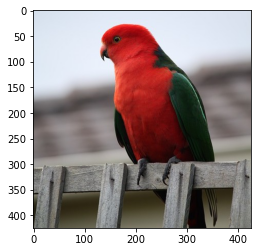

In [3]:
img = Image.open(os.path.join('..', 'assets', 'parrot.jpg')).convert('RGB')
plt.imshow(img)
plt.show()

torch.Size([1, 3, 425, 425])


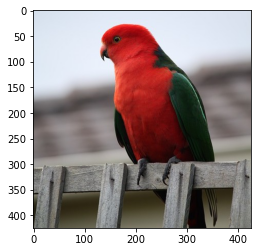

In [4]:
torch_img = transform(img).unsqueeze(0)
print(torch_img.shape)
plt.imshow(tensor2PIL(torch_img))
plt.show()


## Rotation Classification

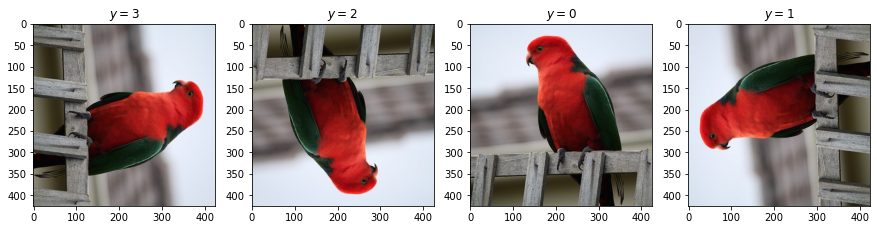

In [11]:
fig, ax = plt.subplots(1, 4, figsize=(15, 12))

collator = RotationCollator(num_rotations=4, rotation_procedure='all')
x, y = collator([[torch_img.squeeze(0),-1]])

for i in range(x.shape[0]):
    ax[i].set_title(r'$y=%d$' % y[i])
    ax[i].imshow(tensor2PIL(x[i]))

plt.show()

# Pretext task

In [12]:
X = torch.rand(50,10,3,425,425) # 500 images, 100 iteration, 
iteration = X.shape[0]
batch_size = X.shape[1]

model = AlexNetRotation()

In [13]:
optimizer = Adam(model.parameters(),lr=0.001)
epochs  = 11


for e in range(1,epochs):
    for ite in X:
        model.zero_grad()
        for data in ite:
            x, y = collator([[data, -1]])
            feat,out = model(x)
            loss = classification_loss(out,y)
            loss.backward()
            optimizer.step()
            

# Downstream Tasks

In [14]:
data2 = torch.rand(10,3,425,425)
label2 = [random.randint(0,10) for x in range(10)]
#feature extraction using trained model.
feature_list = []
model.eval()
with torch.no_grad():
    for data in data2:
        feat,out = model(data.unsqueeze(0))
        feature_list.append(feat.numpy().tolist())
features=np.array(feature_list).squeeze(1)

In [15]:
from sklearn import svm
clf = svm.SVC()
clf.fit(features, label2)

SVC()

In [16]:
clf.predict(features)

array([3, 6, 6, 6, 6, 3, 6, 3, 3, 3])

## Jigsaw Puzzle

Generating Permutation Set: 100%|█████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 261.12it/s]


Minimum hamming distance is chosen as 0.2222
Permutation Configuration:  (3, 2, 6, 8, 5, 7, 0, 1, 4)


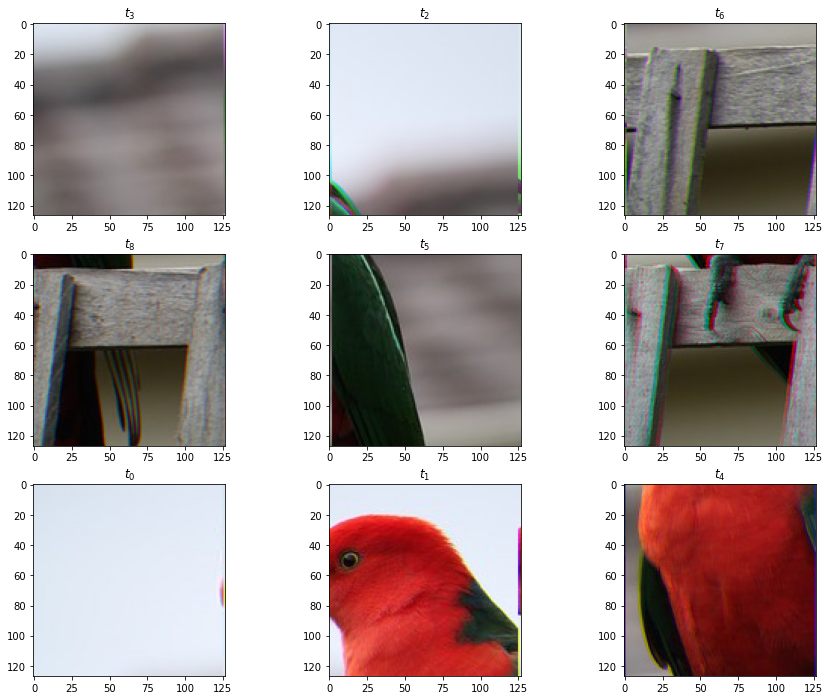

In [5]:
fig, ax = plt.subplots(3, 3, figsize=(15, 12))

collator = JigsawCollator(num_tiles=9, num_permutations=1000, permgen_method='average', 
                          grayscale_probability=0.3, buffer=True, jitter=True, normalization=False)
tiles, y = collator([[torch_img.squeeze(0), -1]])

print('Permutation Configuration: ', collator.permutations[y[0].item()])

for i in range(3):
    for j in range(3):
        ax[i][j].set_title(r'$t_{%d}$' % (collator.permutations[y[0].item()][i * 3 + j]))
        ax[i][j].imshow(tensor2PIL(tiles[i * 3 + j]))
        
plt.show()

# Pretext Task

In [6]:
X2 = torch.rand(2,10,3,425,425) # 500 images, 100 iteration, 
iteration = X2.shape[0]
batch_size = X2.shape[1]

model_jigsaw = AlexNetJigsaw()

In [10]:
optimizer2 = Adam(model_jigsaw.parameters(),lr=0.001)
epochs  = 5

#train loop 
for e in range(1,epochs):
    for ite in X2:
        model_jigsaw.zero_grad()
        for data in ite:
            tiles, y = collator([[data, -1]])
            #print(tiles.shape)
            feat,out = model_jigsaw(tiles)
            loss = classification_loss(out,y)
            loss.backward()
            optimizer2.step()
            

In [ ]:
#Downstream Tasks

# References

https://github.com/uzaymacar/self-supervision